In [5]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt

In [2]:
# States and parameters
CSC = 12
nCSC_10 = 11
nCSC_9 = 10
nCSC_8 = 9
nCSC_7 = 8
nCSC_6 = 7
nCSC_5 = 6
nCSC_4 = 5
nCSC_3 = 4
nCSC_2 = 3
nCSC_1 = 2
DEAD = 1
EMPTY = 0

P_die = 0.01
P_divide = 1/24 # 1 cell cycle in 24 hours
P_migrate = (1-P_divide)*10/24 # 10 spaces in 24 hours
P_asym = 0.9 # probability of asymmetric cell division for cancer stem cells
steps = 250 # hours
reporting_interval = 50

In [3]:
class Cell(object):
    # Public:
    
    # Inputs: loc is list of length 3, pops is list of Population objects,
    #         neighbors is list of Cell objects, state is integer code for state of cell.
    def __init__(self, loc, pops, neighbors={}, state=EMPTY):
        self.location = loc #(loc[0],loc[1],loc[2])
        self.neighbors = neighbors
        self.state = state
        self.listeners = pops
        
    def set_state(self, state):
        last_state = self.state
        # set new state
        self.state = state
        #print(f'{self.location} new state : {self.state}')
        # update populations
        for listener in self.listeners: 
            listener.handle_statechange(self, last_state)
        
        
    def act(self, P_die, P_divide, P_asym, P_migrate, i):
        #print(f'agent {i} ({self.state}) is acting')
        
        # clear dead cell
        if self.state == DEAD:
            self.set_state(EMPTY)
        
        # die or (divide or migrate)
        if self.state != CSC:
            self.die(P_die)
        
        #if self.state != DEAD:
        # choose neighbor
        neighbor = self.choose_neighbor()
        
        # divide or migrate
        #divided = self.divide(neighbor, P_divide, P_asym)
        if self.divide(neighbor, P_divide, P_asym) == False:
            self.migrate(neighbor, P_migrate)
            
        
        #rand = random.random()
        #if rand <= P_divide:
         #   self.divide(neighbor, P_asym) # if didn't divide, still have a chance to migrate
            
        #rand = random.random()
        #elif rand <= P_migrate:
         #   self.migrate(neighbor)
        
    def populate_neighbors(self):
        # coordinates of self.location
        i = self.location[0]
        j = self.location[1]
        k = self.location[2]
            
        # list of all 26 neighbor locations
        neighbor_locs = [(neighbor_i,neighbor_j,neighbor_k) for neighbor_i in [i+1,i-1,i] 
                       for neighbor_j in [j+1,j-1,j] for neighbor_k in [k+1,k-1,k]]
        neighbor_locs.remove(self.location)
        # add new neighbors
        for n in neighbor_locs:
            if n not in list(self.neighbors.keys()):
                neighbor = Cell(n, self.listeners)
                self.receive_intro(neighbor) # add neighbor to self's dictionary
                neighbor.receive_intro(self) # add self to neighbor's dictionary
                
                       
    # Private:
    def die(self, P_die):
        if self.state != (DEAD or EMPTY or CSC):
            rand = random.random()
            if rand <= P_die:
                self.set_state(DEAD)
                #print('agent died \n')
                #return True
            #else:
             #   return False
    
    def choose_neighbor(self):
        neighbors = random.sample(list((self.neighbors).values()), len(self.neighbors))
        for n in neighbors:
            if n.state == EMPTY:
                return n
                break
        return neighbor
    
        #for i in range(100):
         #   neighbor = random.choice(list((self.neighbors).values()))
          #  if neighbor.state == EMPTY:
           #     return neighbor
            #    break
        #return None
    
    def divide(self, neighbor, P_divide, P_asym):
        rand = random.random()
        if rand <= P_divide and neighbor != None and self.state != (DEAD or EMPTY):
            if self.state == CSC:
                rand = random.random()
                if rand <= P_asym: # asymmetric cell division
                    neighbor.set_state(nCSC_10)
                    #print('agent divided asymmetrically \n')
                else: # symmetric cell division
                    neighbor.set_state(CSC)
                    #print('agent (CSC) divided symmetrically \n')
    
            else: # non-CSCs must division symmetrically
                neighbor.set_state(nCSC_10)
                #if last_cell_state > 1:
                self.set_state(self.state - 1) # decrease the proliferative potential down to 1.    
                #print('agent (nCSC) divided symmetrically \n')
            return True
        else:
            return False
        
    def migrate(self, neighbor, P_migrate):
        rand = random.random()
        if rand <= P_migrate and neighbor != None and self.state != (DEAD or EMPTY):
            neighbor.set_state(self.state)
            self.set_state(EMPTY)
            #print('agent migrated \n')
            return True
        else:
            return False
        
    def receive_intro(self, neighbor):
        # put given cell into neighbors
        if type(neighbor) == Cell:
            self.neighbors[neighbor.location] = neighbor
            #print('received intro')

In [4]:
class Population(object):
    # Public
    def __init__(self):
        self.dict = {}
        #self.size = len(self.dict)
        
    # Private
    def add_cell(self, cell):
        if type(cell) == Cell:
            (self.dict)[cell.location]=cell
            #print('added cell')
            
    def remove_cell(self, cell):
        if type(cell) == Cell:
            (self.dict).pop(cell.location)

In [5]:
class FULL_Pop(Population):
    # Public
    def handle_statechange(self, cell, last_state):
        if last_state == EMPTY and cell.state != EMPTY:
            self.add_cell(cell)
            cell.populate_neighbors()
        
    def step(self):
        cap = len(self.dict)
        agents = random.sample(list((self.dict).values()), cap) #random.shuffle(list((self.dict).values()))#
        print(f'full pop size: {len(agents)}')
        for i,agent in enumerate(agents):
            if agent.state != EMPTY:
                #tic = time.perf_counter()
                agent.act(P_die, P_divide, P_asym, P_migrate, i)   
                #toc = time.perf_counter()
                #print(f'duration of act: {toc-tic}')
            #else:
                #print(f'agent {i} is empty')
                
class NonEMPTY_Pop(Population):
    # Public
    def handle_statechange(self, cell, last_state):
        if last_state == EMPTY and cell.state != EMPTY:
            self.add_cell(cell)
        if last_state != EMPTY and cell.state == EMPTY:
            self.remove_cell(cell)
             
    def step(self):
        cap = len(self.dict)
        agents = random.sample(list((self.dict).values()), cap) #random.shuffle(list((self.dict).values()))#
        print(f'nonEMPTY pop size: {len(agents)}')
        for i,agent in enumerate(agents):
            if agent.state != EMPTY:
                #tic = time.perf_counter()
                agent.act(P_die, P_divide, P_asym, P_migrate, i)   
                #toc = time.perf_counter()
                #print(f'duration of act: {toc-tic}')
            #else:
                #print(f'agent {i} is empty')
        
class CSC_Pop(Population):
    # Public
    def handle_statechange(self, cell, last_state):
        if last_state != CSC and cell.state == CSC:
            self.add_cell(cell)
        if last_state == CSC and cell.state != CSC:
            self.remove_cell(cell)
            
class nCSC_Pop(Population):
    # Public
    def handle_statechange(self, cell, last_state):
        ls = last_state
        cs = cell.state
        
        if last_state in list(range(2,12)):
            ls = 'nCSC'
        if cell.state in list(range(2,12)):
            cs = 'nCSC'
        
        #if last_state != (CSC or DEAD or EMPTY):
         #   ls = 'nCSC'
        #if cell.state != (CSC or DEAD or EMPTY):
         #   cs = 'nCSC'
        
        if ls != 'nCSC' and cs == 'nCSC':
            self.add_cell(cell)
        if ls == 'nCSC' and cs != 'nCSC':
            self.remove_cell(cell)
            
class DEAD_Pop(Population):
    # Public
    def handle_statechange(self, cell, last_state):
        if last_state != DEAD and cell.state == DEAD:
            self.add_cell(cell)
        if last_state == DEAD and cell.state != DEAD:
            self.remove_cell(cell)

1 1
nonEMPTY pop size: 1
Completed step 0 

nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 1
nonEMPTY pop size: 2
nonEMPTY pop size: 2
nonEMPTY pop size: 2
nonEMPTY pop size: 2
nonEMPTY pop size: 2
nonEMPTY pop size: 2
nonEMPTY pop size: 2
nonEMPTY pop size: 2
nonEMPTY pop size: 3
nonEMPTY pop size: 3
nonEMPTY pop size: 3
nonEMPTY pop size: 3
nonEMPTY pop size: 3
nonEMPTY pop size: 4
nonEMPTY pop size: 4
nonEMPTY pop size: 6
nonEMPTY pop size: 6
nonEMPTY pop size: 6
nonEMPTY pop size: 6
nonEMPTY po

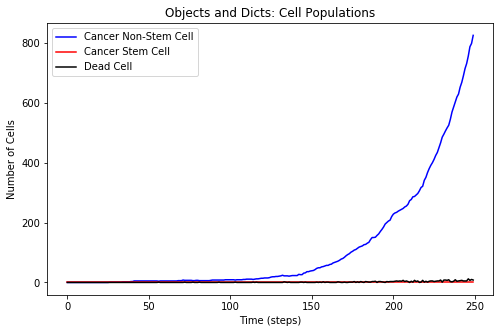

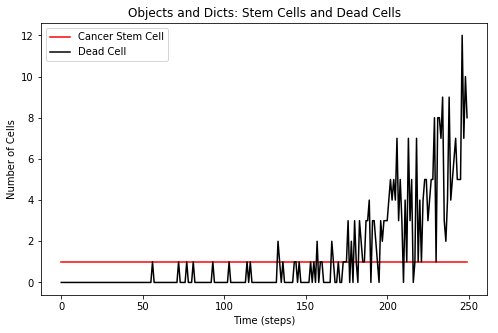

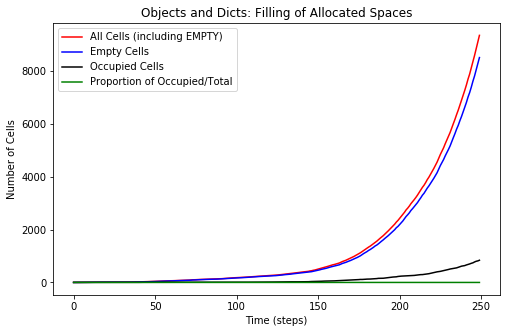

In [6]:
# Run the model. Each step is one hour of activity for one cell.
#def main():
    # create containers for population sizes
num_CSC = []
num_nCSC = []
num_DEAD = []
num_FULL = []
num_EMPTY = []
num_nEMPTY = []
    
# create populations
full_pop = FULL_Pop()
CSC_pop = CSC_Pop()
nCSC_pop = nCSC_Pop()
DEAD_pop = DEAD_Pop()
nEMPTY_pop = NonEMPTY_Pop()
pops = [full_pop, CSC_pop, nCSC_pop, DEAD_pop, nEMPTY_pop]
    
# create root cell
root = Cell((0,0,0), pops)
root.set_state(CSC) # add_to_pop, populate_neighbors in here, should add to CSC and FULL
print(len(full_pop.dict), len(CSC_pop.dict)) #set_state is failing to add to popultations
    
# grow!
tic = time.perf_counter() 
for i in range(steps):
    # pick a cell
    #agent = random.choice(full_pop)
    #agent.act() # updating cells and pops happens in here
    nEMPTY_pop.step() # or full_pop.step()
    num_CSC.append(len(CSC_pop.dict))
    num_nCSC.append(len(nCSC_pop.dict))
    num_DEAD.append(len(DEAD_pop.dict))
    num_FULL.append(len(full_pop.dict))
    num_nEMPTY.append(len(nEMPTY_pop.dict))
    num_EMPTY.append(len(full_pop.dict)-len(nEMPTY_pop.dict))
            
    if i%reporting_interval == 0:
        print(f'Completed step {i} \n')
            
toc = time.perf_counter() 
print(f'Time to finish {steps} steps: {toc-tic}')
    
# Save population counts
np.save(f'CSC_counts_obj_{steps}_2.npy', num_CSC)
np.save(f'nCSC_counts_obj_{steps}_2.npy', num_nCSC)
np.save(f'DEAD_counts_obj_{steps}_2.npy', num_DEAD)
np.save(f'FULL_counts_obj_{steps}_2.npy', num_FULL)
    
# plot populations
fig = plt.figure(figsize=(8, 5))
plt.plot(num_nCSC, c='b', label='Cancer Non-Stem Cell')
plt.plot(num_CSC, c='r', label='Cancer Stem Cell')
plt.plot(num_DEAD, c='k', label='Dead Cell')
plt.legend()
plt.title('Objects and Dicts: Cell Populations')
plt.xlabel('Time (steps)')
plt.ylabel('Number of Cells')
plt.savefig('obj_sim_3.jpg')
    
fig = plt.figure(figsize=(8, 5))
plt.plot(num_CSC, c='r', label='Cancer Stem Cell')
plt.plot(num_DEAD, c='k', label='Dead Cell')
plt.legend()
plt.title('Objects and Dicts: Stem Cells and Dead Cells')
plt.xlabel('Time (steps)')
plt.ylabel('Number of Cells')
plt.savefig('obj_sim_3_justCSCDEAD.jpg')
    
fig = plt.figure(figsize=(8, 5))
plt.plot(num_FULL, c='r', label='All Cells (including EMPTY)')
plt.plot(num_EMPTY, c='b', label='Empty Cells')
plt.plot(num_nEMPTY, c='k', label='Occupied Cells')
plt.plot([1/j for i,j in zip(num_nEMPTY,num_FULL)] , c='g', label='Proportion of Occupied/Total')
plt.legend()
plt.title('Objects and Dicts: Filling of Allocated Spaces')
plt.xlabel('Time (steps)')
plt.ylabel('Number of Cells')
plt.savefig('obj_sim_3_fullpop.jpg')

In [6]:
num_CSC = np.load('CSC_counts_obj_250_2.npy')
num_nCSC = np.load('nCSC_counts_obj_250_2.npy')
num_DEAD = np.load(f'DEAD_counts_obj_250_2.npy')
num_FULL = np.load(f'FULL_counts_obj_250_2.npy')

C:\Users\mzb56\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\mzb56\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


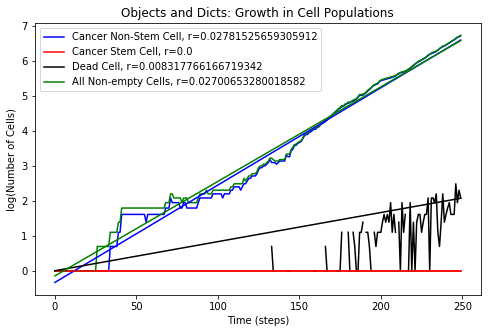

In [9]:
log_CSC = np.log(num_CSC)
log_nCSC = np.log(num_nCSC)
log_DEAD = np.log(num_DEAD)
log_Occ = np.log(num_CSC + num_nCSC + num_DEAD)

x = range(250)
# y = the logs
slope_CSC = (log_CSC[-1])/250
intercept_CSC = 0
#slope_nCSC = (log_nCSC[-1])/250
#intercept_nCSC = 0
slope_DEAD = (log_DEAD[-1]/250)
intercept_DEAD = 0

#slope_CSC, intercept_CSC = np.polyfit(x, log_CSC, 1)
slope_nCSC, intercept_nCSC = np.polyfit(x[30:], log_nCSC[30:], 1)
#slope_DEAD, intercept_DEAD = np.polyfit(x[225:], log_DEAD[225:], 1)
slope_Occ, intercept_Occ = np.polyfit(x, log_Occ, 1)

fig = plt.figure(figsize=(8, 5))
# plot the logs
plt.plot(log_nCSC, c='b', label=f'Cancer Non-Stem Cell, r={slope_nCSC}')
plt.plot(log_CSC, c='r', label=f'Cancer Stem Cell, r={slope_CSC}')
plt.plot(log_DEAD, c='k', label=f'Dead Cell, r={slope_DEAD}')
plt.plot(log_Occ, c='g', label=f'All Non-empty Cells, r={slope_Occ}')

# plot the lines
plt.plot(x, slope_nCSC*x + intercept_nCSC, c='b')
plt.plot(x, slope_CSC*x + intercept_CSC, c='r')
plt.plot(x, slope_DEAD*x + intercept_DEAD, c='k')
plt.plot(x, slope_Occ*x + intercept_Occ, c='g')
    
plt.legend()
plt.title('Objects and Dicts: Growth in Cell Populations')
plt.xlabel('Time (steps)')
plt.ylabel('log(Number of Cells)')
plt.savefig('obj_log_3.jpg')
    